# Sentiment Analysis for Mental Health Using BERT

# Data Collection

**About Dataset**

This comprehensive dataset is a meticulously curated collection of mental health statuses tagged from various statements. The dataset amalgamates raw data from multiple sources, cleaned and compiled to create a robust resource for developing chatbots and performing sentiment analysis.
https://www.kaggle.com/code/swarnabh31/nlp-bert-sentimentanalysis-mentalhealth

**Data Source:**

The dataset integrates information from the following Kaggle datasets:

* 3k Conversations Dataset for Chatbot
* Depression Reddit Cleaned
* Human Stress Prediction
* Predicting Anxiety in Mental Health Data
* Mental Health Dataset Bipolar
* Reddit Mental Health Data
* Students Anxiety and Depression Dataset
* Suicidal Mental Health Dataset
* Suicidal Tweet Detection Dataset

**Data Overview:**

The dataset consists of statements tagged with one of the following seven mental health statuses:

* Normal
* Depression
* Suicidal
* Anxiety
* Stress
* Bi-Polar
* Personality Disorder

**Acknowledgments:**

This dataset was created by aggregating and cleaning data from various publicly available datasets on Kaggle. Special thanks to the original dataset creators for their contributions.

In [ ]:
!pip install -q kaggle

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
!kaggle datasets download -d suchintikasarkar/sentiment-analysis-for-mental-health
!unzip sentiment-analysis-for-mental-health.zip


Dataset URL: https://www.kaggle.com/datasets/suchintikasarkar/sentiment-analysis-for-mental-health
License(s): DbCL-1.0
 63% 7.00M/11.1M [00:00<00:00, 71.3MB/s]
100% 11.1M/11.1M [00:00<00:00, 53.8MB/s]
Archive:  sentiment-analysis-for-mental-health.zip
  inflating: Combined Data.csv       


In [ ]:
df = pd.read_csv("Combined Data.csv")
df

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...,...
53038,53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


In [ ]:
df.drop(columns=["Unnamed: 0"], inplace=True)

In [ ]:
def get_df_info(df):
    print("\n\033[1mShape of DataFrame:\033[0m ", df.shape)
    print("\n\033[1mColumns in DataFrame:\033[0m ", df.columns.to_list())
    print("\n\033[1mData types of columns:\033[0m\n", df.dtypes)

    print("\n\033[1mInformation about DataFrame:\033[0m")
    df.info()

    print("\n\033[1mNumber of unique values in each column:\033[0m")
    for col in df.columns:
        print(f"\033[1m{col}\033[0m: {df[col].nunique()}")

    print("\n\033[1mNumber of null values in each column:\033[0m\n", df.isnull().sum())

    print("\n\033[1mNumber of duplicate rows:\033[0m ", df.duplicated().sum())

    print("\n\033[1mDescriptive statistics of DataFrame:\033[0m\n",)

    return df.describe().transpose()

In [ ]:
get_df_info(df)


Shape of DataFrame:  (53043, 2)

Columns in DataFrame:  ['statement', 'status']

Data types of columns:
 statement    object
status       object
dtype: object

Information about DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 828.9+ KB

Number of unique values in each column:
statement: 51073
status: 7

Number of null values in each column:
 statement    362
status         0
dtype: int64

Number of duplicate rows:  1944

Descriptive statistics of DataFrame:



,count,unique,top,freq
statement,52681,51073,what do you mean?,22
status,53043,7,Normal,16351


Here, The dataset has some null and duplicate rows, below these are chosen to be removed.

In [ ]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

In [ ]:
df['status'].value_counts()

,count
status,
1,16040
2,15094
3,10644
0,3623
5,2501
4,2296
6,895


Here, the classes are highly imbalanced. so reduce the model's biasness towards any particular class, the data needs to be balanced. In my opinion, the best approach would have been downsample the majority class to a certain range and upsample the minority class with augmentation function such as back translation and word replacement with synonyms. However, due to low computational device power and resources, i have decided to downsample it to 500 rows for each class. To keep the original pattern of the data, here i'm only going to resample the train set.



In [ ]:
import random

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import resample

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from transformers import get_scheduler
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
# label mapping
label_mapping = {label: i for i, label in enumerate(df['status'].unique())}
df['status'] = df['status'].map(label_mapping)

# Train - Validation - Test Split

In [ ]:
x = df.drop(columns=["status"])
y = df["status"]

# First, split into Train (80%) and Test (20%)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=40, stratify=y)

# Then, split the train set into Train (80%) and Validation (20%)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=40, stratify=y_train)

print(f"Training Set: {x_train.shape}, Validation Set: {x_val.shape}, Test Set: {x_test.shape}")


Training Set: (32699, 1), Validation Set: (8175, 1), Test Set: (10219, 1)


# Data Resampling (Downsampling)

In [ ]:
train_df = pd.concat([x_train, y_train], axis=1)

# Downsample all classes to 650
df_balanced = train_df.groupby('status', group_keys=False).apply(
    lambda x: x.sample(n=500, random_state=42)
)

# Shuffle dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate features and labels again
x_train_balanced = df_balanced.drop(columns=['status'])
y_train_balanced = df_balanced['status']

# Check new class distribution
print(y_train_balanced.value_counts())

status
3    500
4    500
0    500
2    500
5    500
6    500
1    500
Name: count, dtype: int64


<ipython-input-28-58b3f51530b2>:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = train_df.groupby('status', group_keys=False).apply(


# Model Fine tuning, Training and Testing (BERT)

In [ ]:
train_labels = y_train_balanced.tolist()
val_labels = y_val.tolist()
test_labels = y_test.tolist()

In [ ]:
class MentalHealthDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.encodings["input_ids"][idx]),
            "attention_mask": torch.tensor(self.encodings["attention_mask"][idx]),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
        }

    def __len__(self):
        return len(self.labels)


In [ ]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=7)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
text_column = "statement"
train_encodings = tokenizer(x_train_balanced[text_column].tolist(), truncation=True, padding=True)
val_encodings = tokenizer(x_val[text_column].tolist(), truncation=True, padding=True)
test_encodings = tokenizer(x_test[text_column].tolist(), truncation=True, padding=True)


In [ ]:
# dataset instances
train_dataset = MentalHealthDataset(train_encodings, train_labels)
val_dataset = MentalHealthDataset(val_encodings, val_labels)
test_dataset = MentalHealthDataset(test_encodings, test_labels)

In [ ]:
# data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
# Define device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Define optimizer, loss function, and scheduler
optimizer = optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8)
loss_fn = nn.CrossEntropyLoss()
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * 5)

# Early stopping parameters
best_val_loss = float("inf")
patience = 2
patience_counter = 0


def evaluate_model(model, loader, device):
    model.eval()
    total_correct = 0
    total_loss = 0
    count = 0

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            count += 1

            _, predicted = torch.max(outputs.logits, dim=1)
            total_correct += (predicted == labels).sum().item()

    if count == 0:
        return 0, 0

    accuracy = total_correct / len(loader.dataset)
    average_loss = total_loss / count
    return accuracy, average_loss

# Train model
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(5):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()

    train_losses.append(total_loss / len(train_loader))
    train_accuracy, _ = evaluate_model(model, train_loader, device)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_accuracy, val_loss = evaluate_model(model, val_loader, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')
    print(f'Train Accuracy: {train_accuracies[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}')

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered. Stopping training.")
            break

# Load best model
model.load_state_dict(torch.load("best_model.pth"))


Epoch 1, Train Loss: 1.4038, Val Loss: 0.9107
Train Accuracy: 0.7357, Val Accuracy: 0.6554
Epoch 2, Train Loss: 0.6808, Val Loss: 0.6517
Train Accuracy: 0.8634, Val Accuracy: 0.7541
Epoch 3, Train Loss: 0.4401, Val Loss: 0.6287
Train Accuracy: 0.9174, Val Accuracy: 0.7689
Epoch 4, Train Loss: 0.2975, Val Loss: 0.6396
Train Accuracy: 0.9471, Val Accuracy: 0.7662
Epoch 5, Train Loss: 0.2139, Val Loss: 0.6588
Train Accuracy: 0.9637, Val Accuracy: 0.7703
Early stopping triggered. Stopping training.


<ipython-input-36-6bfad43c99d8>:89: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


<All keys matched successfully>


Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.87      0.81       580
           1       0.95      0.87      0.91      2567
           2       0.78      0.65      0.71      2415
           3       0.67      0.73      0.70      1703
           4       0.51      0.77      0.61       367
           5       0.65      0.85      0.74       400
           6       0.47      0.76      0.58       143

    accuracy                           0.77      8175
   macro avg       0.69      0.79      0.72      8175
weighted avg       0.79      0.77      0.77      8175



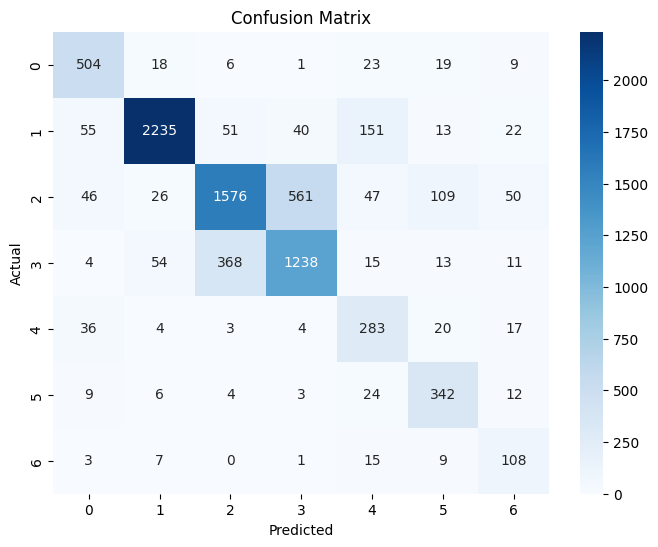

In [ ]:
# Get predictions and true labels
model.eval()
true_labels, pred_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

# Classification Report
print("\nClassification Report:\n", classification_report(true_labels, pred_labels))

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=set(y_train_balanced), yticklabels=set(y_train_balanced))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



Test Loss: 0.6159
Test Accuracy: 0.7729

Test Set Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.88      0.80       725
           1       0.96      0.88      0.92      3208
           2       0.80      0.64      0.71      3019
           3       0.67      0.76      0.71      2129
           4       0.50      0.77      0.60       459
           5       0.67      0.85      0.75       500
           6       0.45      0.72      0.55       179

    accuracy                           0.77     10219
   macro avg       0.68      0.78      0.72     10219
weighted avg       0.79      0.77      0.78     10219



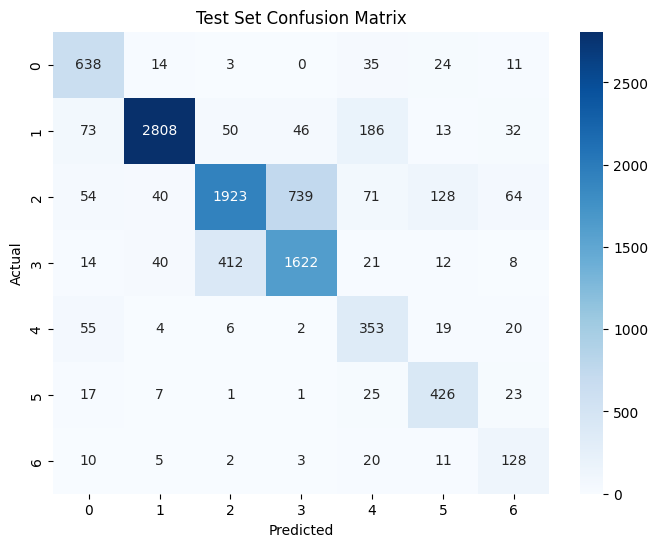

In [ ]:
# Evaluate model on test set
test_accuracy, test_loss = evaluate_model(model, test_loader, device)

print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predictions and true labels for test set
model.eval()
true_labels, pred_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())



print("\nTest Set Classification Report:\n", classification_report(true_labels, pred_labels))

# Plot confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=set(y_train_balanced), yticklabels=set(y_train_balanced))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Test Set Confusion Matrix")
plt.show()


In [ ]:
print("\nFinal Model Performance:")
print(f"Train Accuracy: {train_accuracies[-1]:.4f}, Train Loss: {train_losses[-1]:.4f}")
print(f"Validation Accuracy: {val_accuracies[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}")



Final Model Performance:
Train Accuracy: 0.9637, Train Loss: 0.2139
Validation Accuracy: 0.7703, Validation Loss: 0.6588
Test Accuracy: 0.7729, Test Loss: 0.6159


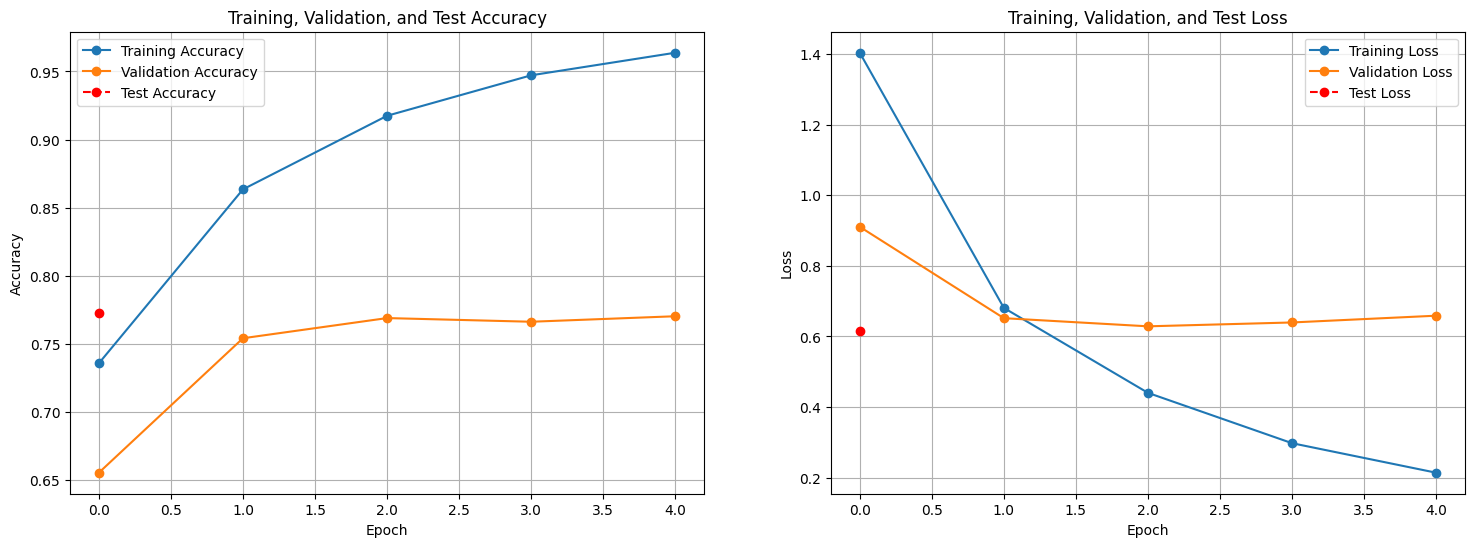

In [ ]:
plt.figure(figsize=(18, 6))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='o')
plt.plot(test_accuracy, label='Test Accuracy', marker='o', linestyle='dashed', color='red')
plt.legend()
plt.title('Training, Validation, and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.plot(test_loss, label='Test Loss', marker='o', linestyle='dashed', color='red')
plt.legend()
plt.title('Training, Validation, and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.show()


In [ ]:
from transformers import AutoConfig, AutoModelForSequenceClassification

model_path = "best_model.pth"

# Load the same config used during training
config = AutoConfig.from_pretrained("bert-base-uncased", num_labels=7)

# Initialize model correctly
model = AutoModelForSequenceClassification.from_config(config)

# Load trained weights
model.load_state_dict(torch.load(model_path, map_location=torch.device("cpu"), weights_only= True))
model.eval()

print("Model loaded successfully.")


Model loaded successfully.


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
test_text = "I've been having trouble sleeping, and I feel anxious all the time.."
inputs = tokenizer(test_text, return_tensors="pt", truncation=True, padding=True)

with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    prediction = torch.argmax(logits, dim=1).item()

print("Predicted Label:", prediction)


Predicted Label: 0
